<a href="https://colab.research.google.com/github/MatanNoach/NeuralNetworksPatent/blob/master/SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One-Time Commands
### This will download nltk datasets, and clone github repository with the latest data
### When you finish working, make sure to click File -> Save a copy in GitHub -> 

In [23]:
# A cell for running one-time commands ("!pip install" etc.)
import nltk
nltk.download("stopwords")

!git clone https://github.com/MatanNoach/NeuralNetworksPatent.git
%cd NeuralNetworksPatent/
!ls

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Cloning into 'NeuralNetworksPatent'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 3), reused 8 (delta 1), pack-reused 0
Unpacking objects: 100% (14/14), done.
/content/NeuralNetworksPatent
BalancedTweets.csv  README.md  SentimentAnalysis.ipynb


In [24]:
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
from keras import models
from keras import layers
from keras import regularizers

from sklearn.model_selection import train_test_split

In [25]:
NB_WORDS = 10000  # Parameter indicating the number of words we'll put in the dictionary
VAL_SIZE = 1000  # Size of the validation set
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

# Pre Processing

In [26]:
# Packages for data preparation
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split()
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    return " ".join(clean_words)


def remove_mentions(input_text):
    return re.sub(r'@\w+', '', input_text)

def apply_token(X_train,X_test,num_words):
    tk = Tokenizer(num_words=num_words,
                   filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                   lower=True,
                   split=" ")
    tk.fit_on_texts(X_train)

    print('Fitted tokenizer on {} documents'.format(tk.document_count))
    print('{} words in dictionary'.format(tk.num_words))
    print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))
    
    X_train_seq = tk.texts_to_sequences(X_train)
    X_test_seq = tk.texts_to_sequences(X_test)

    print('"{}" is converted into {}'.format(X_train[0], X_train_seq[0]))
    return X_train_seq, X_test_seq

def one_hot_seq(seqs, nb_features):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

def classes_to_numbers(y_train,y_test):
    le = LabelEncoder()
    y_train_le = le.fit_transform(y_train)
    y_test_le = le.transform(y_test)
    y_train_oh = to_categorical(y_train_le)
    y_test_oh = to_categorical(y_test_le)

    print('"{}" is converted into {}'.format(y_train[0], y_train_le[0]))
    print('"{}" is converted into {}'.format(y_train_le[0], y_train_oh[0]))
    return y_train_oh, y_test_oh

In [27]:
# A function that balances the data to 50% negative and 50% positive
def balance_data():
  df = pd.read_csv('/content/drive/MyDrive/Patent/Tweets.csv') # Load the data
  # Get only the negative and positive data
  negative_df = df.loc[df['airline_sentiment']=="negative"]
  positive_df = df.loc[df['airline_sentiment']=="positive"]
  # Get negative rows as the number of positive rows
  negative_df = negative_df[0:len(positive_df.index)]
  # Combine both rows
  df = pd.concat([negative_df,positive_df])
  print(len(df.index))
  # Save to csv without the indexes
  df.to_csv('/content/drive/MyDrive/Patent/BalancedTweets.csv',index=False)

# balance_data()

# Data Preparation

In [28]:
df = pd.read_csv('./BalancedTweets.csv') # Load the data
df = df.reindex(np.random.permutation(df.index)) # Shuffle the data
df = df[['text', 'airline_sentiment']] # Extract only relevant columns

df.text = df.text.apply(remove_stopwords).apply(remove_mentions) # Apply preprocessing
df.head()

,text,airline_sentiment
2324,&amp; I've hung twice staff. So upset right,negative
4166,603 &amp; 2705 DFW PSP thank you!,positive
3680,great see RedSox plane reminder ❤️NY side sid...,positive
2265,"no- boarding- can't agents, phone, taking car...",negative
3354,"I'm excited too, perhaps could scale exciteme...",positive


In [29]:
# Split to train and test data
X_train, X_test, y_train, y_test = train_test_split(df.text, df.airline_sentiment, test_size=0.1, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 4253
# Test data samples: 473


In [30]:
# Transform x data to one hot vector
X_train_seq, X_test_seq = apply_token(X_train,X_test,NB_WORDS)
X_train_oh = one_hot_seq(X_train_seq,NB_WORDS)
X_test_oh = one_hot_seq(X_test_seq,NB_WORDS)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

Fitted tokenizer on 4253 documents
10000 words in dictionary
Top 5 most common words are: [('flight', 973), ('thanks', 620), ('thank', 432), ('you', 426), ('not', 388)]
" really aggressive blast obnoxious "entertainment" guests' faces &amp; little recourse" is converted into [262, 333, 157, 116, 434]
"[262, 333, 157, 116, 434]" is converted into [0. 0. 0. ... 0. 0. 0.]
For this example we have 5.0 features with a value of 1.


In [31]:
# Transform yo data to one hot vector
y_train_oh, y_test_oh = classes_to_numbers(y_train,y_test)

"negative" is converted into 1
"1" is converted into [0. 1.]


In [32]:
# Split to validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_train_oh, y_train_oh, test_size=0.1, random_state=37)

assert X_valid.shape[0] == y_valid.shape[0]
assert X_train.shape[0] == y_train.shape[0]

print('Shape of validation set:',X_valid.shape)

Shape of validation set: (426, 10000)


# The Model

In [33]:
epochs = 15

def plot_metric(result, metric_name):
    metric = result.history[metric_name]
    val_metric = result.history['val_' + metric_name]

    e = range(1, epochs + 1)
    plt.title(metric_name)
    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def train_model(model):
    model.compile(optimizer='adam'
              , loss='categorical_crossentropy'
              , metrics=['accuracy'])
    
    result = model.fit(X_train
              , y_train
              , epochs=epochs
              , batch_size=BATCH_SIZE
              , validation_data=(X_valid,y_valid)
              , verbose=0)
    return result
def evaluate(model):
    results = model.evaluate(X_test_oh, y_test_oh)
    print('/n')
    print('Test accuracy of model: {0:.2f}%'.format(results[1]*100))

In [34]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(NB_WORDS,)))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.7))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                640064    
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 2)                 34        
                                                                 
Total params: 642,706
Trainable params: 642,706
Non-trai

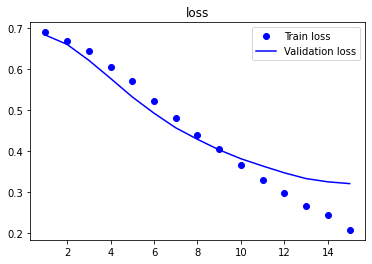

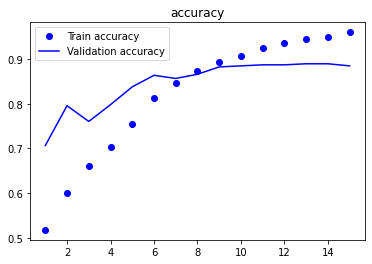

15/15 [==============================] - 0s 3ms/step - loss: 0.3013 - accuracy: 0.9112
/n
Test accuracy of model: 91.12%


In [35]:
result = train_model(model)
plot_metric(result, 'loss')
plot_metric(result, 'accuracy')
evaluate(model)